*Библиотеки*

In [240]:
import ccxt
import pandas as pd
import numpy as np
import requests

import vectorbt as vbt

import pyarrow as pa
import pyarrow.parquet as pq
import duckdb

import quantstats as qs
import empyrical as emp

from datetime import datetime, timezone

*Настройки*

In [3]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 0)

**Функции**

In [2]:
# Объем измеряется в количестве актива проторгованном за свечу (т.е 100 биткоинов было проторговано за эту часовую/минутную/дневную свечу)
def fetch_ohlcv_df(exchange, symbol, timeframe, start, end):
    start_ms = int(pd.Timestamp(start, tz="UTC").timestamp() * 1000)
    end_ms = int(pd.Timestamp(end, tz="UTC").timestamp() * 1000)

    data = []
    since = start_ms

    while since < end_ms:
        batch = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
        if not batch:
            break
        data.extend(batch)
        since = batch[-1][0] + 1

    df = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
    df = df.set_index("timestamp")
    return df.loc[start:end]

In [271]:
def moex_fetch_ohlcv_df(ticker, timeframe, start, end, board="TQBR"):
    tf = {"1m":1, "5m":5, "10m":10, "15m":15, "30m":30, "1h":60, "2h":120, "4h":240, "1d":1440}
    interval = tf[timeframe]

    url = f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/{board}/securities/{ticker}/candles.json"
    start_ts = pd.Timestamp(start, tz="UTC")
    end_ts   = pd.Timestamp(end, tz="UTC")

    rows, off = [], 0
    while True:
        r = requests.get(url, params={"from": start, "till": end, "interval": interval, "start": off}).json()["candles"]
        chunk = r["data"]
        if not chunk:
            break
        rows += chunk
        off += len(chunk)

    df = pd.DataFrame(rows, columns=r["columns"])
    df["timestamp"] = pd.to_datetime(df["begin"]).dt.tz_localize("Europe/Moscow").dt.tz_convert("UTC")
    df = df.set_index("timestamp")[["open","high","low","close","volume"]]
    return df.loc[start_ts:end_ts]

**Байбит**

In [3]:
exchange = ccxt.binance({"enableRateLimit": True})

*Проверка работоспособности*

In [222]:
df = fetch_ohlcv_df(
    exchange,
    "BTC/USDT",
    "1h",
    "2025-02-02",
    "2026-02-02"
)

In [238]:
df

,open,high,low,close,volume,ema_50,ema_14,sma_50,sma_14,rsi_14,volume_sma_200
timestamp,,,,,,,,,,,
2025-02-10 07:00:00+00:00,97142.43,97482.87,97108.88,97429.83,755.46407,96594.358943,96634.651286,96450.8964,96392.707857,60.259600,1320.106292
2025-02-10 08:00:00+00:00,97429.83,97899.99,97358.79,97683.99,1238.61637,96637.089573,96774.563115,96484.6852,96497.850000,61.595238,1323.173928
2025-02-10 09:00:00+00:00,97684.00,97880.33,97451.73,97664.78,659.22257,96677.391158,96893.258700,96513.7824,96612.138571,62.863423,1324.686164
2025-02-10 10:00:00+00:00,97664.77,97954.69,97589.94,97728.29,1021.79544,96718.602877,97004.596206,96550.4714,96712.570714,61.667787,1326.237904
2025-02-10 11:00:00+00:00,97728.29,97899.00,97599.88,97661.16,600.83887,96755.565902,97092.138045,96580.4336,96890.240714,75.155440,1314.881927
...,...,...,...,...,...,...,...,...,...,...,...
2026-02-02 19:00:00+00:00,78569.83,78697.99,78283.27,78341.50,1074.65868,78581.238871,78053.170728,77876.8866,77894.581429,74.622519,1131.139331
2026-02-02 20:00:00+00:00,78341.50,78667.38,77888.00,78008.59,902.54602,78558.782052,78047.226631,77876.2908,77998.815000,64.443785,1134.006570
2026-02-02 21:00:00+00:00,78008.59,78552.76,77922.00,78532.06,507.24426,78557.734129,78111.871080,77891.9318,78132.477143,67.125038,1135.152492


In [274]:
df = moex_fetch_ohlcv_df(
    "SBER",
    "1h",
    "2025-02-02",
    "2026-02-02"
)

In [275]:
df

,open,high,low,close,volume
timestamp,,,,,
2025-02-03 03:00:00+00:00,280.21,280.21,280.21,280.21,38500
2025-02-03 04:00:00+00:00,280.21,280.27,278.59,279.82,1330910
2025-02-03 05:00:00+00:00,279.82,279.86,279.23,279.74,576150
2025-02-03 06:00:00+00:00,279.74,280.35,279.36,279.46,996490
2025-02-03 07:00:00+00:00,279.46,279.65,278.00,278.51,5974420
...,...,...,...,...,...
2026-01-31 11:00:00+00:00,305.57,305.60,305.49,305.59,41656
2026-01-31 12:00:00+00:00,305.59,305.70,305.48,305.65,92817
2026-01-31 13:00:00+00:00,305.66,305.68,305.48,305.62,55762


In [276]:
df[['open','high','low','close']].vbt.ohlc.plot() # Работает только без объема почему-то. ohlcv при добавлении объема не работает!

FigureWidget({
    'data': [{'close': {'bdata': ('j8L1KFyDcUCF61G4Hn1xQKRwPQrXe3' ... 'XrGXNACtejcD0ac0AzMzMzMxtzQA=='),
                        'dtype': 'f8'},
              'decreasing': {'line': {'color': '#d95f02'}},
              'high': {'bdata': ('j8L1KFyDcUC4HoXrUYRxQPYoXI/CfX' ... 'fhGnNACtejcD0ac0BI4XoUrhtzQA=='),
                       'dtype': 'f8'},
              'increasing': {'line': {'color': '#1b9e76'}},
              'low': {'bdata': ('j8L1KFyDcUA9CtejcGlxQEjhehSuc3' ... 'SuF3NAcT0K16MYc0AAAAAAABhzQA=='),
                      'dtype': 'f8'},
              'name': 'OHLC',
              'open': {'bdata': ('j8L1KFyDcUCPwvUoXINxQIXrUbgefX' ... 'yPGnNAUrgehesZc0AK16NwPRpzQA=='),
                       'dtype': 'f8'},
              'type': 'ohlc',
              'uid': '98139d93-db55-4b4e-880d-4cff796fb2f0',
              'x': array([Timestamp('2025-02-03 03:00:00+0000', tz='UTC'),
                          Timestamp('2025-02-03 04:00:00+0000', tz='UTC'),
                  

In [277]:
close = df['close']

df['ema_50'] = vbt.MA.run(close, window = 50, ewm = True).ma
df['ema_14'] = vbt.MA.run(close, window = 14, ewm = True).ma
df['sma_50'] = vbt.MA.run(close, window = 50, ewm = False).ma
df['sma_14'] = vbt.MA.run(close,window = 14, ewm = False).ma
df['rsi_14'] = vbt.RSI.run(close, window = 14).rsi
df['volume_sma_200'] = vbt.MA.run(df['volume'],window = 200, ewm = False).ma

In [278]:
df = df.dropna()

In [279]:
df.tail(25)

,open,high,low,close,volume,ema_50,ema_14,sma_50,sma_14,rsi_14,volume_sma_200
timestamp,,,,,,,,,,,
2026-01-30 06:00:00+00:00,308.35,308.50,307.44,308.35,1244619,306.127683,307.592545,305.6394,307.827857,60.056391,1093267.275
2026-01-30 07:00:00+00:00,308.35,308.48,306.54,307.58,2232892,306.184637,307.590872,305.7068,307.908571,55.058192,1103783.100
2026-01-30 08:00:00+00:00,307.58,307.62,305.00,305.09,4758842,306.141710,307.257423,305.7242,307.826429,45.724907,1127279.780
2026-01-30 09:00:00+00:00,305.16,305.21,304.50,305.04,4168806,306.098506,306.961766,305.7432,307.554286,32.506887,1147818.975
2026-01-30 10:00:00+00:00,305.05,306.26,304.85,305.86,2632715,306.089153,306.814864,305.7586,307.250000,29.597701,1160708.200
2026-01-30 11:00:00+00:00,305.82,306.16,305.34,305.63,641350,306.071147,306.656882,305.7688,307.110000,37.960688,1163907.140
2026-01-30 12:00:00+00:00,305.61,305.89,305.07,305.11,533063,306.033455,306.450631,305.7708,306.975000,38.289963,1164753.845
2026-01-30 13:00:00+00:00,305.10,305.50,304.87,305.37,1031104,306.007437,306.306547,305.7754,306.861429,40.410133,1169477.845
2026-01-30 14:00:00+00:00,305.38,305.50,305.06,305.42,1457527,305.984400,306.188341,305.7784,306.730000,38.557214,1176466.445


<Axes: xlabel='timestamp'>

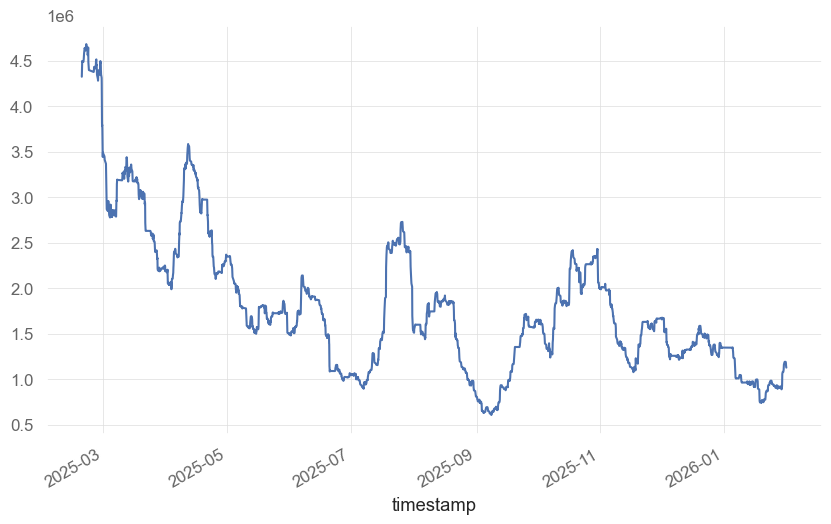

In [280]:
df['volume_sma_200'].plot()

**Тестовая стратегия**

In [309]:
entries = (df['close'] > df["ema_50"]) & (df['volume'] > df['volume_sma_200'])
exits   = (df['close'] < df["ema_50"])

In [310]:
close = df['close']
pf = vbt.Portfolio.from_signals(close, entries, exits, freq="1h")
pf.stats()

Start                         2025-02-18 08:00:00+00:00
End                           2026-01-31 15:00:00+00:00
Period                                209 days 16:00:00
Start Value                                       100.0
End Value                                     97.851274
Total Return [%]                              -2.148726
Benchmark Return [%]                          -2.689798
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              13.209103
Max Drawdown Duration                 119 days 09:00:00
Total Trades                                        103
Total Closed Trades                                 103
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  29.126214
Best Trade [%]                                  5.86602
Worst Trade [%]                               -5

<Axes: xlabel='timestamp'>

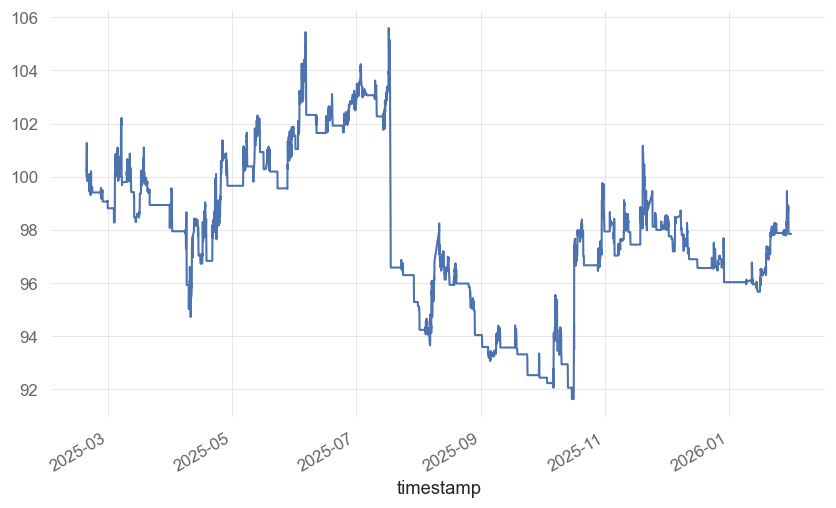

In [287]:
pf.trades.records_readable
pf.value().plot()

In [ ]:
close = df["close"]
ema = df["ema_50"]
vol = df["volume"]

w = 50
k = 3.0
n = 4

vol_mean = vol.rolling(w).mean()
vol_std  = vol.rolling(w).std()
spike = vol > (vol_mean + k * vol_std)

bull = df["close"] > df["open"]
bear = df["close"] < df["open"]

prev4_bull = bull.shift(1).rolling(n).sum() == n
prev4_bear = bear.shift(1).rolling(n).sum() == n

short_entries_raw = spike & bull & prev4_bull
long_entries_raw  = spike & bear & prev4_bear

long_entries  = long_entries_raw.shift(1).fillna(False)
short_entries = short_entries_raw.shift(1).fillna(False)

cross_ema_up   = (ema.shift(1) < close.shift(1)) & (ema >= close)   # EMA crosses above price
cross_ema_down = (ema.shift(1) > close.shift(1)) & (ema <= close)   # EMA crosses below price

long_exits  = cross_ema_up.shift(1).fillna(False)
short_exits = cross_ema_down.shift(1).fillna(False)


/var/folders/wv/62jmd95s1f14n4w8zh58m7680000gn/T/ipykernel_42041/1737182391.py:22: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/wv/62jmd95s1f14n4w8zh58m7680000gn/T/ipykernel_42041/1737182391.py:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/wv/62jmd95s1f14n4w8zh58m7680000gn/T/ipykernel_42041/1737182391.py:28: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_

Start                         2025-02-18 08:00:00+00:00
End                           2026-01-31 15:00:00+00:00
Period                                209 days 16:00:00
Start Value                                       100.0
End Value                                    100.909527
Total Return [%]                               0.909527
Benchmark Return [%]                          -2.689798
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              10.132276
Max Drawdown Duration                 144 days 13:00:00
Total Trades                                          8
Total Closed Trades                                   8
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       50.0
Best Trade [%]                                 4.743153
Worst Trade [%]                                -

<Axes: xlabel='timestamp'>

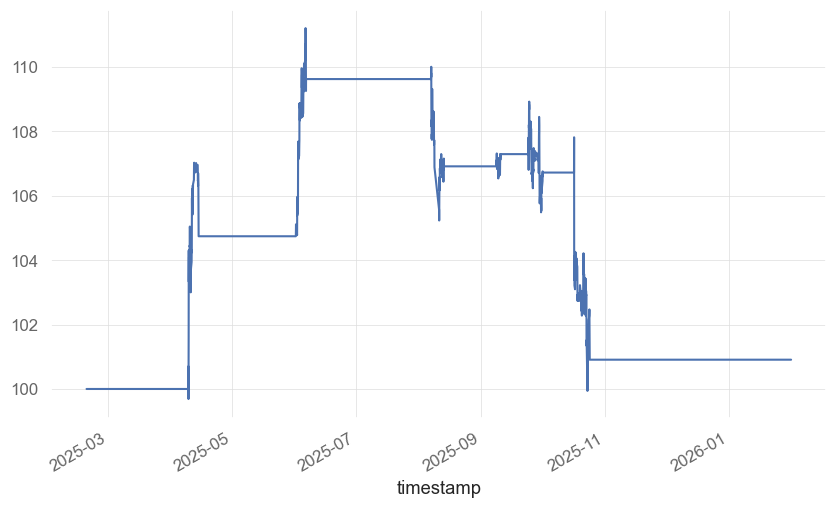

In [302]:
pf = vbt.Portfolio.from_signals(
    close,
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    freq="1h",
)
print(pf.stats())
pf.trades.records_readable
pf.value().plot()